## Bank Term Deposit Acceptance forecasting

Obiettivo di questo assignment è la valutazione delle competenze tecniche del candidato e la sua modalità di approccio ad un problema di Data Science. Nello specifico è richiesto di sviluppare un modello predittivo in grado di indicare se un cliente intercettato da una campagna di marketing da parte di una banca decide di sottoscrivere o meno un deposito bancario a termine (bank term deposit).

#### Dataset: ####

All'interno della cartella **data**  viene fornito il file **bank-dataset.csv** che contiene le campagne marketing telefoniche effettuate da una banca per proporre l'acquisto del prodotto bancario.
I dettagli del dataset sono forniti all'interno del file: **bank-names.txt**.
La variabile target che indica se il cliente accetta o meno la sottoscrizione del deposito bancario è contenuta nel medesimo file con field name "y".

#### Assignement: ####

Richiesta di questo assignment è la costruzione di un modello predittivo con performance soddisfacenti per il candidato dando evidenza di tutti gli step tipici che dovrebbero essere affrontati in un progetto di Data Science: dalla pulizia e preparazione del dato fino al testing delle performance del modello costruito.

Il notebook svolto dovrà essere opportunamente commentato e dovrà essere consegnato tramite condivisione di un repository github personale accessibile che ne permetta la riproduzione.

## Overview

Throughout this notebook we will build a classification model to determine whether a customer will subscribe a long term deposit after a marketing campaign.

**Business Problem**: build a system that helps the marketing department identifying customers to target with future marketing campaigns.

**Value Proposition**: reduce the spending in the marketing department while increasing subscriptions.

Being this a marketing dataset this is an **imbalanced classification problem**, the number of samples which subscribe the long term deposit is a small minority with respect to the whole population. In a marketing campaing the most people do not subscribe a long term deposit, as it is to be expected.

Our main aim is building **a model that identifies subscribing customers**. In particular, misclassifying a non-subscribing customer (False Positive) is tolerable while misclassifying a subscribing customer as non-subscribing (False Negative) is expensive thus not tolerable.

For this reasons, we want to **maximize recall** that is the fraction of subscribing customers correctly identified. However, we cannot take into account recall by itself because to maximize it we may classify all samples as subscribing by building a naive classifier. We take into account also F-beta, the weighted harmonic mean of precision and recall, to have a measure of the dependability of our model. In particular, we score our models with respect to **F2 macro** which gives greater importance to recall while giving the same weight to both classes.

See the table below for an overview of the scores achieved by the models tested.


| Model                                                     | Recall   | F2 Macro |
|-----------------------------------------------------------|----------|----------|
| Weighted Logistic Regression                              | 0.77     | 0.72     |
| Logistic Regression with Resampling                       | 0.67     | 0.73     |
| Weighted Logistic Regression with Resampling              | 0.67     | 0.73     |
| Weighted XGBoost with Optimal Partitioning                | 0.76     | 0.76     |
| Weighted XGBoost with Onehot Encoding                     | 0.77     | 0.77     |
| XGBoost with Optimal Partitioning and Resampling          | 0.79     | 0.77     |
| XGBoost with Onehot Encoding and Resampling               | 0.77     | 0.77     |
| Weighted XGBoost with Optimal Partitioning and Resampling | **0.84** | **0.76** |
| Weighted XGBoost with Onehot Encoding and Resampling      | 0.81     | 0.75     |

All the above models have been trained on a training set which was used to identify the best hyperparameters through **random grid search and stratified cross-validation**. Finally the models have been scored on a validation set to build the scores you see above.

**Best Model**: Weighted XGBoost with Optimal Paritioning and Resampling

**Test Set Score**:
- Recall: 0.82
- F2 Macro: 0.76

Finally, we discussed the interpretation of the model and found out that **last call duration is crucial for customer subscriptions**. In particular, the longer the last call the most important towards determining customer subscription.

## Notebook Setup
Set training to **False to load all the models from checkpoints** saved in the *models* directories.

Set training to **True to train the models from scratch** and reproduce the checkpoints.

In [518]:
training = False

## Data Loading 

In [519]:
# load the dataset from the csv file
import pandas as pd
dataset = pd.read_csv("data/bank-dataset.csv")
dataset.describe(include="all")

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
count,43074.000000,43097,43097,43097,43097,43097.000000,43097,43097,43039,43097.000000,43097,43021.000000,43097.000000,43097.000000,43097.000000,43087,43097
unique,NaN,12,7,4,2,NaN,2,2,3,NaN,12,NaN,NaN,NaN,NaN,4,2
top,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,unknown,no
freq,NaN,9448,26102,22242,42298,NaN,24336,36039,27574,NaN,13386,NaN,NaN,NaN,NaN,35598,39925
mean,41.297674,NaN,NaN,NaN,NaN,1342.323596,NaN,NaN,NaN,15.858157,NaN,244.533251,2.796622,38.725155,0.550154,NaN,NaN
std,12.240857,NaN,NaN,NaN,NaN,2990.087062,NaN,NaN,NaN,8.429079,NaN,239.982705,3.144191,98.700477,2.280486,NaN,NaN
min,18.000000,NaN,NaN,NaN,NaN,-8019.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,1.000000,-1.000000,0.000000,NaN,NaN
25%,33.000000,NaN,NaN,NaN,NaN,67.000000,NaN,NaN,NaN,8.000000,NaN,100.000000,1.000000,-1.000000,0.000000,NaN,NaN
50%,39.000000,NaN,NaN,NaN,NaN,437.000000,NaN,NaN,NaN,16.000000,NaN,174.000000,2.000000,-1.000000,0.000000,NaN,NaN
75%,48.000000,NaN,NaN,NaN,NaN,1400.000000,NaN,NaN,NaN,21.000000,NaN,303.000000,3.000000,-1.000000,0.000000,NaN,NaN


## Data Preparation

### Dealing with Incomplete Samples
**Some data points are incomplete** (missing some features). From the previous description we see that there are some features with a count lower than the total number of samples:
- age
- duration
- poutcome

For age and duration we simply remove the samples because both are numeric features and the number of missing values is not very large. Due to the low number of samples there is **no need to impute** the missing values.

For poutcome we instead fill all the missing values with unkown as poutcome is a categorical variable and unknown is already present among the categories. 

In [520]:
# filling all the holes in poutcome with unknown
dataset["poutcome"] = dataset["poutcome"].fillna("unknown")

In [521]:
dataset = dataset.dropna(axis=0)
dataset.describe(include="all")

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
count,42941.000000,42941,42941,42941,42941,42941.000000,42941,42941,42941,42941.000000,42941,42941.000000,42941.000000,42941.000000,42941.000000,42941,42941
unique,NaN,12,7,4,2,NaN,2,2,3,NaN,12,NaN,NaN,NaN,NaN,4,2
top,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,unknown,no
freq,NaN,9410,26012,22165,42142,NaN,24256,35907,27530,NaN,13361,NaN,NaN,NaN,NaN,35532,39777
mean,41.302345,NaN,NaN,NaN,NaN,1341.952423,NaN,NaN,NaN,15.861973,NaN,244.701684,2.790387,38.144058,0.543863,NaN,NaN
std,12.249340,NaN,NaN,NaN,NaN,2992.254091,NaN,NaN,NaN,8.431028,NaN,239.923994,3.122571,97.106389,2.264130,NaN,NaN
min,18.000000,NaN,NaN,NaN,NaN,-8019.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,1.000000,-1.000000,0.000000,NaN,NaN
25%,33.000000,NaN,NaN,NaN,NaN,67.000000,NaN,NaN,NaN,8.000000,NaN,101.000000,1.000000,-1.000000,0.000000,NaN,NaN
50%,39.000000,NaN,NaN,NaN,NaN,436.000000,NaN,NaN,NaN,16.000000,NaN,174.000000,2.000000,-1.000000,0.000000,NaN,NaN
75%,48.000000,NaN,NaN,NaN,NaN,1398.000000,NaN,NaN,NaN,21.000000,NaN,303.000000,3.000000,-1.000000,0.000000,NaN,NaN


### Removing Duplicates
We identify **8 duplicated samples** and remove them.

In [522]:
dataset_with_duplicates_len = len(dataset)
dataset = dataset.drop_duplicates()
duplicates = dataset_with_duplicates_len - len(dataset)
print("Removed " + str(duplicates) + " duplicates")


Removed 8 duplicates


### Cleaning Invalid Data
Some features may take values which make no sense thus we filter the dataset with respect to the following rules:
- 18 =< age <= 116 (116 is the longest living person recorded);
- balance >= 0 (in a term deposit you cannot have negative balance);
- 1 =< day <= 31;
- duration > 0;
- campaign >= 0;
- pdays >= -1;
- previous >= 0;
- all categorical features must take values among the ones specified in *bank-names.txt*.

In [523]:
import calendar

job_categories = ["admin.",
                  "unknown",
                  "unemployed",
                  "management",
                  "housemaid",
                  "entrepreneur",
                  "student",
                  "blue-collar",
                  "self-employed",
                  "retired",
                  "technician",
                  "services"]

marital_categories = ["married",
                      "divorced", # means divorced/widowed
                      "single"]

education_categories = ["unknown",
                        "primary",
                        "secondary",
                        "tertiary"]

contact_categories = ["unknown", 
                      "telephone", 
                      "cellular"]

poutcome_categories = ["unknown",
                       "other",
                       "failure",
                       "success"]

# jan, feb, mar, ...
months = [month.lower() for month in list(calendar.month_abbr)[1:]]

yes_or_no = ["yes", "no"]

In [524]:
filtering_rules = [dataset["age"] >= 18,
                  dataset["age"] <= 116,
                  dataset["balance"] >= 0,
                  dataset["day"] >= 1,
                  dataset["day"] <= 31,
                  dataset["duration"] >= 0,
                  dataset["campaign"] >= 0,
                  dataset["pdays"] >= -1,
                  dataset["previous"] >= 0,
                  dataset["job"].isin(job_categories),
                  dataset["marital"].isin(marital_categories),
                  dataset["education"].isin(education_categories),
                  dataset["default"].isin(yes_or_no),
                  dataset["housing"].isin(yes_or_no),
                  dataset["loan"].isin(yes_or_no), 
                  dataset["contact"].isin(contact_categories),
                  dataset["month"].isin(months),
                  dataset["poutcome"].isin(poutcome_categories),
                  dataset["y"].isin(yes_or_no)]

In [525]:
from functools import reduce
from typing import List

def rules_and(rule_1: pd.Series, rule_2: pd.Series) -> pd.Series:
    """wraps the '&' operator"""
    return rule_1 & rule_2

def apply_filtering_rules(dataset: pd.DataFrame, 
                          filtering_rules: List[pd.Series]) -> pd.DataFrame:
    """
    applies some filtering rules to a dataset, 
    returns the filtered dataset
    """
    return dataset[reduce(rules_and, filtering_rules)]

In [526]:
dataset = apply_filtering_rules(dataset, filtering_rules)
dataset.describe(include="all")


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
count,38940.000000,38940,38940,38940,38940,38940.000000,38940,38940,38940,38940.000000,38940,38940.000000,38940.000000,38940.000000,38940.000000,38940,38940
unique,NaN,12,3,4,2,NaN,2,2,3,NaN,12,NaN,NaN,NaN,NaN,4,2
top,NaN,management,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,unknown,no
freq,NaN,8306,23803,19722,38572,NaN,21468,33110,25223,NaN,11624,NaN,NaN,NaN,NaN,32047,35942
mean,41.052799,NaN,NaN,NaN,NaN,1499.304468,NaN,NaN,NaN,15.787134,NaN,245.177196,2.778197,38.566718,0.558038,NaN,NaN
std,10.461762,NaN,NaN,NaN,NaN,3086.156046,NaN,NaN,NaN,8.282566,NaN,240.684489,3.093156,97.068963,2.320955,NaN,NaN
min,18.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,1.000000,-1.000000,0.000000,NaN,NaN
25%,33.000000,NaN,NaN,NaN,NaN,144.000000,NaN,NaN,NaN,8.000000,NaN,100.000000,1.000000,-1.000000,0.000000,NaN,NaN
50%,39.000000,NaN,NaN,NaN,NaN,533.000000,NaN,NaN,NaN,16.000000,NaN,174.000000,2.000000,-1.000000,0.000000,NaN,NaN
75%,49.000000,NaN,NaN,NaN,NaN,1564.250000,NaN,NaN,NaN,21.000000,NaN,304.250000,3.000000,-1.000000,0.000000,NaN,NaN


### Feature Encoding
We one-hot encode all categorical features.

To enhance interpretability we choose the following **reference categories**:
- all binary variables use the natural encoding where 1 represents yes and 0 represents no
- all variables having an 'unknown' category use such category as reference
- the reference month is may as it is the most frequent
- the reference marital status is 'single'

In [527]:
numerical_features = ["age", 
                      "balance", 
                      "day", 
                      "duration",
                      "campaign",
                      "pdays", 
                      "previous"]
categorical_features = list(set(dataset.columns) - set(numerical_features) - {"y"})

In [528]:
import pandas as pd
from typing import List

def onehot_encode(dataset: pd.DataFrame, feature: str) -> pd.DataFrame:
    """One-hot encode a given feature in a given dataset.
    Returns the dataset with the feature encoded."""
    encoded_feature = pd.get_dummies(dataset[[feature]], dtype=int)
    output_dataset = pd.concat([dataset, encoded_feature], axis=1)
    output_dataset = output_dataset.drop([feature], axis=1)
    return output_dataset

def onehot_encode_all(dataset: pd.DataFrame, features: List[str]) -> pd.DataFrame:
    """One-hot encode all the given features in a given dataset.
    Returns the dataset with the feature encoded."""
    return reduce(onehot_encode, features, dataset)


In [529]:
encoded_dataset = onehot_encode_all(dataset, categorical_features + ["y"])

In [530]:
# to avoid collinearity issues we must drop one column per categorical variable

reference_categories = ["loan_no", 
                        "poutcome_unknown", 
                        "housing_no", 
                        "job_unknown", 
                        "default_no", 
                        "marital_single", 
                        "education_unknown", 
                        "contact_unknown", 
                        "y_no",
                        "month_may"]

encoded_dataset=encoded_dataset.drop(columns=reference_categories)

## Preliminary Analysis
Several features have severe imbalances:
- 61% of the sample is married;
- 50% of the sample has secondary education;
- 99% of the sample does not have credit in default;
- 55% of the samples represent people with a housing loan;
- 85% of the samples represent people with a loan;
- 65% of the sample has been contacted with a cellular;
- 30% of the sample received the last contact in may;
- 82% of the samples have an unknown outcome for the previous campaign.

The **target variable 'y' is severely imbalanced** too, 92% of the samples did not subscribe the term deposit.

Age has a less skewed distribution with 75% of the samples with an age lower than 50 but with many samples in the 30-40 range, in particular **32 years old people are the most abundant in this dataset**.

**75% of the sample has a balance lower than 1566 euros** and 12% of the sample has a balance between 0 and 20 euros. However, there are also higher balances reaching a maximum balance of 102.127 euros.

In general the dataset contains a specific subset of people skewed towards:
- low balance
- no credit in default
- a loan
- married
- lower than 50 years old
- not subscribing the term deposit after the campaign



### Data Exploration

In [531]:
dataset.describe(include="all")

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
count,38940.000000,38940,38940,38940,38940,38940.000000,38940,38940,38940,38940.000000,38940,38940.000000,38940.000000,38940.000000,38940.000000,38940,38940
unique,NaN,12,3,4,2,NaN,2,2,3,NaN,12,NaN,NaN,NaN,NaN,4,2
top,NaN,management,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,unknown,no
freq,NaN,8306,23803,19722,38572,NaN,21468,33110,25223,NaN,11624,NaN,NaN,NaN,NaN,32047,35942
mean,41.052799,NaN,NaN,NaN,NaN,1499.304468,NaN,NaN,NaN,15.787134,NaN,245.177196,2.778197,38.566718,0.558038,NaN,NaN
std,10.461762,NaN,NaN,NaN,NaN,3086.156046,NaN,NaN,NaN,8.282566,NaN,240.684489,3.093156,97.068963,2.320955,NaN,NaN
min,18.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,1.000000,-1.000000,0.000000,NaN,NaN
25%,33.000000,NaN,NaN,NaN,NaN,144.000000,NaN,NaN,NaN,8.000000,NaN,100.000000,1.000000,-1.000000,0.000000,NaN,NaN
50%,39.000000,NaN,NaN,NaN,NaN,533.000000,NaN,NaN,NaN,16.000000,NaN,174.000000,2.000000,-1.000000,0.000000,NaN,NaN
75%,49.000000,NaN,NaN,NaN,NaN,1564.250000,NaN,NaN,NaN,21.000000,NaN,304.250000,3.000000,-1.000000,0.000000,NaN,NaN


In [532]:
from plotly.graph_objs._figure import Figure
import plotly.express as px 

def make_histogram(dataset: pd.DataFrame,
                   feature: str,
                   color: str) -> Figure:
  """Plot a feature from a given dataset as a histogram"""
  histogram = px.histogram(dataset, x=feature)
  histogram.update_traces(marker_color=color)
  return histogram

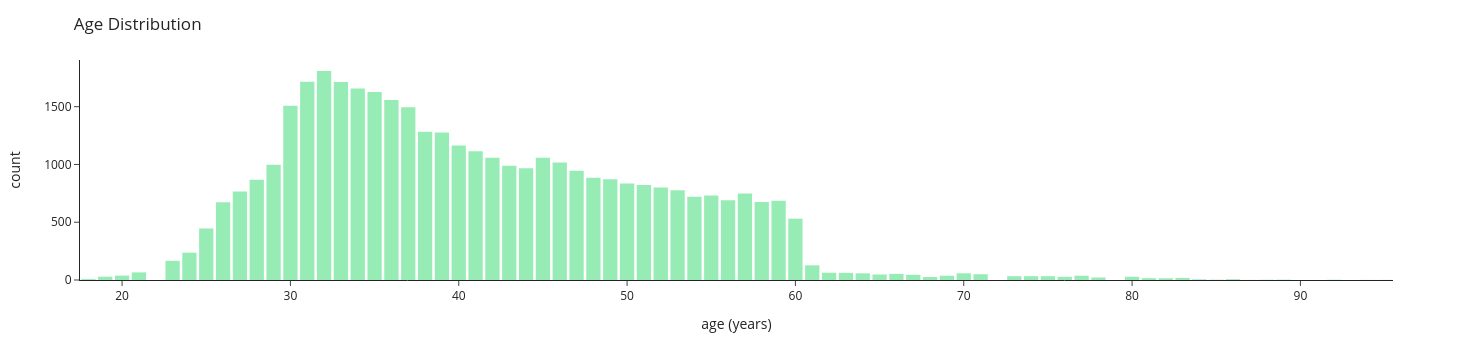

In [533]:
plot = make_histogram(dataset, "age", "#53E185") 
plot.update_traces(marker_line_width=0, opacity=0.6)
plot["layout"]["xaxis"]["title"] = "age (years)"
plot.update_layout(template="simple_white", bargap=0.15, title="Age Distribution")

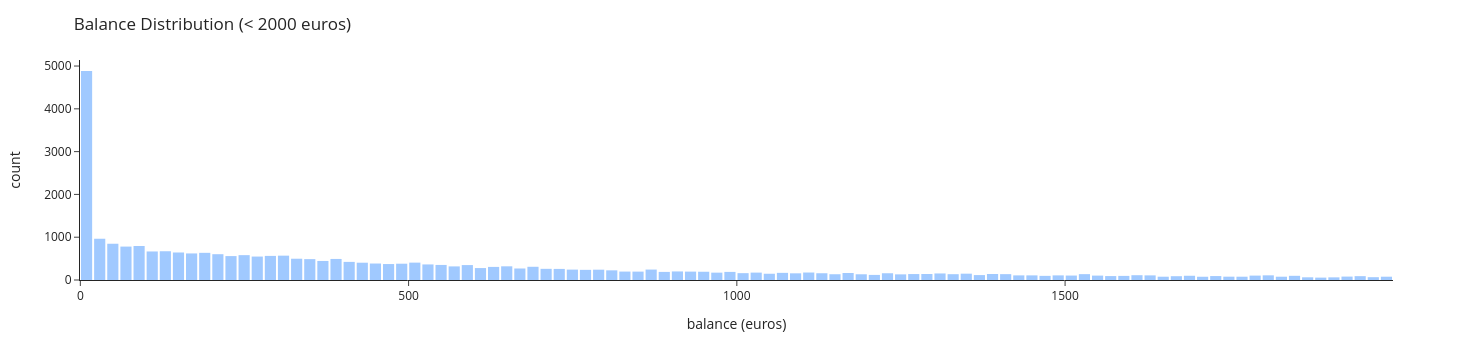

In [534]:
plot = make_histogram(dataset[dataset["balance"] < 2000], "balance", "#62a6ff") 
plot.update_traces(marker_line_width=0, opacity=0.6)
plot["layout"]["xaxis"]["title"] = "balance (euros)"
plot.update_layout(template="simple_white", bargap=0.15, title="Balance Distribution (< 2000 euros)")

### Correlation
We check for linear correlation among numerical features because such correlation may negatively impact classification performance.

**We do not find relevant correlation**

In [535]:
from plotly.graph_objs._figure import Figure
import plotly.express as px
from typing import Literal
import numpy as np
import pandas as pd


def plot_correlation_matrix(dataset: pd.DataFrame) -> Figure:
  """Plot lower triangle of the (Pearson's) correlation matrix 
  among all the columns of the given dataset"""
  correlation_matrix = dataset.corr().abs().round(2)
  correlation_matrix_np = correlation_matrix.to_numpy()  
  upper_triangle_indices = np.triu_indices(correlation_matrix_np.shape[0], k=1)
  correlation_matrix_np[upper_triangle_indices] = np.nan
  correlation_matrix = pd.DataFrame(correlation_matrix_np, index=correlation_matrix.index, columns=correlation_matrix.columns)
  heatmap = px.imshow(correlation_matrix, text_auto=True, color_continuous_scale="viridis")
  heatmap.update_layout(
      font_size=18
  )
  heatmap.update_yaxes(ticksuffix = "  ")
  heatmap.update_xaxes(ticksuffix = "  ")
  heatmap.update_layout(
    autosize=False,
    width=500,
    height=500,
    plot_bgcolor = "white"  
  )
  return heatmap


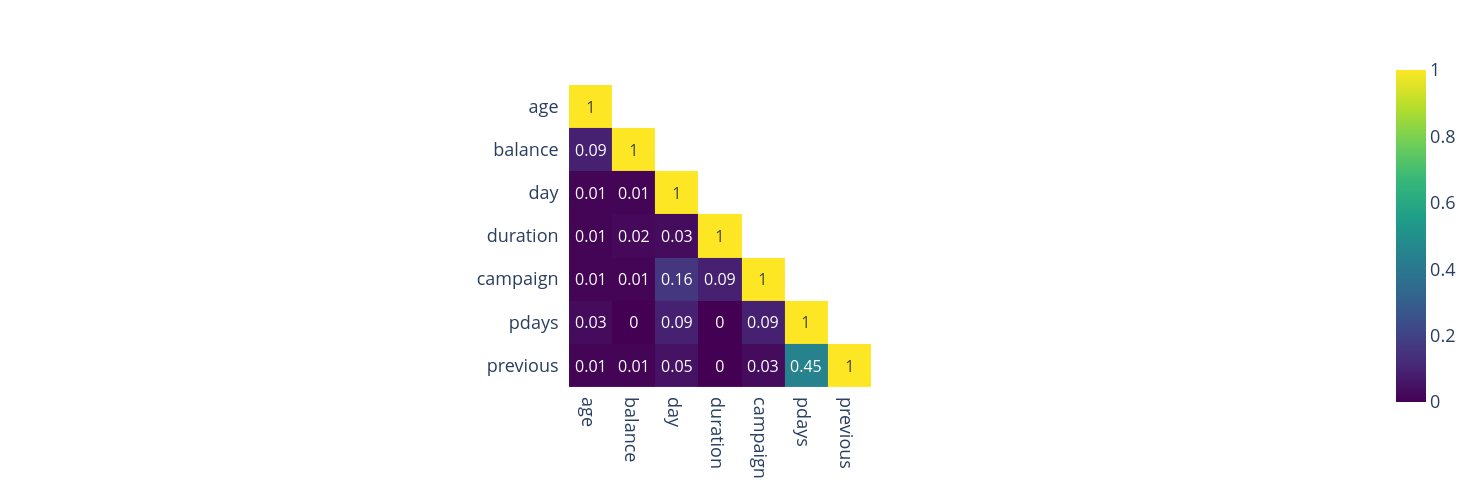

In [536]:
plot_correlation_matrix(dataset[numerical_features])

## Train/Test Split
The dataset is split in train and test set (80/20). We employ **stratification** so as to respect the class imbalance both in the train and in the test set

In [537]:
from sklearn.model_selection import train_test_split
from typing import Tuple
import pandas as pd

def split(dataset: pd.DataFrame, 
          target_column: str, 
          split_rate: float = 0.2, 
          random_state: int = 0) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Splits the dataset in train and test.
    'split_rate'*100 determines the percentage of samples in the test set.
    'random_state' sets the seed of the random splitter for reproducibility.
    Returns train set, train targets, test set and test targets"""
    target = dataset[target_column]
    train, test = train_test_split(dataset, stratify=target, test_size=split_rate, random_state=random_state)
    train_target = train[target_column]
    train = train.drop(columns=[target_column])
    test_target = test[target_column]
    test = test.drop(columns=[target_column])
    return train, train_target, test, test_target

In [538]:
# Split dataset in train, validation and test
train_validation, train_validation_target, test, test_target = split(dataset, "y")

train_validation_full = train_validation.assign(y=train_validation_target)
train, train_target, validation, validation_target = split(train_validation_full, "y")

## Mapping target to yes -> 1 and no -> 0
target_mapping = {"yes": 1, "no": 0}
train_target = train_target.replace(target_mapping)
validation_target = validation_target.replace(target_mapping)
test_target = test_target.replace(target_mapping)

## Setting type "category" to categorical columns
categorical_typing = dict(zip(categorical_features,  ["category"]*len(categorical_features)))
train = train.astype(categorical_typing)
validation = validation.astype(categorical_typing)
test = test.astype(categorical_typing)

# Split one-hot encoded dataset in train, validation and test
(encoded_train_validation,
 _,
 encoded_test,
 _) = split(encoded_dataset, "y_yes")

encoded_train_validation_full = encoded_train_validation.assign(y=train_validation_target)
encoded_train, _, encoded_validation, _ = split(encoded_train_validation_full, "y")

# Split one-hot encoded normalized dataset in train, validation and test
normalized_dataset=(encoded_dataset-encoded_dataset.min())/(encoded_dataset.max()- encoded_dataset.min())
(normalized_train_validation, 
 _, 
 normalized_test,
 _) = split(normalized_dataset, "y_yes")

normalized_train_validation_full = normalized_train_validation.assign(y=train_validation_target)
normalized_train, _, normalized_validation, _ = split(normalized_train_validation_full, "y")


## Classification

### Model Serialization
Belowe we define functions to save model checkpoints to file and retrieve checkpoints from file.

In [539]:
from joblib import dump, load
from sklearn.base import BaseEstimator

def save(model: BaseEstimator, file_path: str) -> None:
    dump(model, file_path)
    
def load_model(file_path: str) -> BaseEstimator:
    return load(file_path)

### Model Selection
We want a model that correctly identifies the highest number of important customer even if there are some false positives. 

In our scenario **false negatives are costly** thus we select models given the **f2 macro** score. 

The f1 score can be interpreted as the harmonic mean between precision and recall. We want to give recall greater importance as we want to maximize the number of correctly identified important customers even if this means misclassifying some less important customers. The f2 score allows us to **give greater importance to recall** with respect to precision. Given the imbalance in our dataset we use macro aggregation to give the same importance to both classes regardless the number of samples.

Given the low number of samples we select models using **stratified cross-validation**. Specifically, for each model we set an hyperparameter space and for each model we explore such space through **random sampling** and evaluate each model through stratified cross-validation

In [540]:
from sklearn.metrics import fbeta_score, make_scorer

f2_macro_score = make_scorer(fbeta_score, beta=2, average="macro")

In [541]:
from sklearn.base import BaseEstimator
from typing import Dict, Iterable, Union, Callable, Any, Type
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import numpy as np
import pandas as pd
from pathlib import Path
import datetime


def select_model(model: BaseEstimator,
                 name: str,
                 hyperparameters: Dict[str, Iterable[Any]],
                 train: pd.DataFrame,
                 target: pd.Series,
                 iterations: int,
                 scoring_function: Union[str, Callable[[BaseEstimator, np.array, np.array], float]] = f2_macro_score,
                 cv_splits: int = 3,
                 verbose: int=3, 
                 random_state: int=0) -> BaseEstimator:
    """Select a given model from a given hyperparameter space using random grid search, save it as.
    The model will be saved with the given name plus the current timestamp.
    Models are evaluated through cross-validation and the folds are stratified to retain class imbalance.
    Train represents the training set and target is the associated series of targets.
    'Iterations' determines how many random samples are drawn from the hyperparameter space.
    All models are scored through the scoring function, all sklearn scoring functions are supported.
    'cv_splits' determines the number of stratified cross-validation splits used to evaluate each model.
    'Verbose' determines the logging granularity during model selection.
    'Random_state' sets the random state of the model and of the random grid search."""
        
    hyperparameter_search = RandomizedSearchCV(
                           model, 
                           hyperparameters, 
                           scoring=scoring_function,
                           cv=StratifiedKFold(n_splits=cv_splits),
                           n_iter=iterations,
                           verbose=verbose,
                           random_state=random_state)

    hyperparameter_search.fit(train, target)
    best_model = hyperparameter_search.best_estimator_
    timestamp = str(datetime.datetime.now()).replace(" ", "_").replace(".", "_")
    save(best_model, name + "_" + timestamp + ".joblib")
    return hyperparameter_search.best_estimator_

### Model Evaluation
As noted above we want to evaluate models on recall, for this reason we evaluate models on recall and f2 macro:
- **Recall**: tells us how many of the subscribing customers our model correctly identifies
- **F2 Macro**: tells us how dependable our classifier giving equal importance to majority and minority class while emphasizing recall with respect to precision

Along these two metrics we also display a confusion matrix to give a more general idea of the classifiers' performance

In [542]:
from sklearn.base import BaseEstimator
from sklearn.metrics import average_precision_score, recall_score, fbeta_score
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay


def evaluate(predictions: pd.Series, target: pd.Series) -> None:
    """Evaluate an estimator with respect to given test samples and targets"""
    recall = recall_score(target, predictions)
    f2_macro = fbeta_score(target, predictions, beta=2, average="macro")
    print("Recall: " + str(recall))
    print("F2 Macro: " + str(f2_macro))
    ConfusionMatrixDisplay.from_predictions(target, 
                                            predictions, 
                                            normalize="true", 
                                            display_labels=["No Subscribtion", "Subscription"])
    

### Dealing with Class Imbalance

#### Class Weighting
Many models allow to give weights to classes to account for class imbalance.

#### Resampling
Resampling allows to account for class imbalance by undersampling the majority class and/or oversampling the minority class.

When mixing oversampling and undersampling one must **choose the new proportion between minority and majority samples**.

It is usually advised against making the minority class a new majority class in order to avoid creating a new imbalance.

In our case we **explore the space of possible ratios through cross-validation**:
- the minority is upsampled to a new ratio between 0.1 to 0.3 of the majority class
- the majority is downsampled to a new ratio between 0.5 and 0.7 of the minority class

In [543]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

random_over_sampler = RandomOverSampler()
random_under_sampler = RandomUnderSampler()

resampling_hyperparameters = {"oversampling__random_state": [0],
                              "oversampling__sampling_strategy": np.linspace(0.1, 0.3),
                              "undersampling__random_state": [0],
                              "undersampling__sampling_strategy": np.linspace(0.5, 0.7)}

### Naive Classifier: Always Predict the Minority Class
Given the importance we give to the minority class, **the best naive strategy is always predicting the minority class**. In our case this means predicting that every customer will subscribe a long term deposit.

This predictor obviously achieves perfect recall but a very low F2 Macro.

Recall: 1.0
F2 Macro: 0.14722119985277882


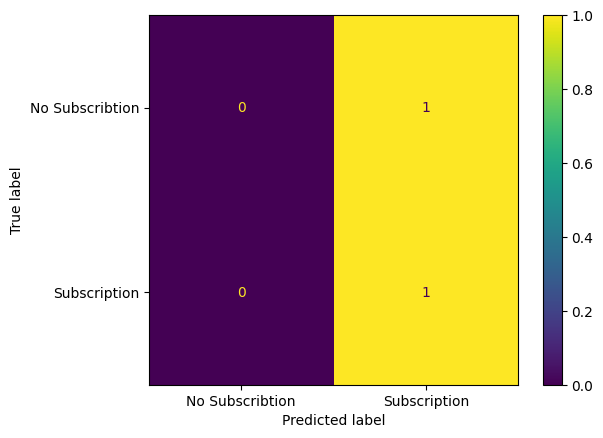

In [544]:
predictions = pd.Series([1]*len(validation_target))
evaluate(predictions, validation_target)

### Logistic Regression
Logistic Regression is a fairly simple model which will work as a **baseline for our future experiments**.

#### Class Weighting

In [545]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

if not training:
    weighted_logit = load_model("models/weighted_logit.joblib")
    
else:
    logit_to_train = LogisticRegression(random_state=0)

    logit_hyperparameters = { "C": np.logspace(-4, 4), # from 10^-4 to 10^4 evenly spaced
                               "penalty": ["elasticnet"],
                               "l1_ratio": np.linspace(0, 1),
                               "solver": ["saga"],
                               "class_weight": ["balanced"]}

    weighted_logit = select_model(model=logit_to_train,
                                  name="weighted_logit",
                                  train=normalized_train,
                                  target=train_target,
                                  hyperparameters=logit_hyperparameters, 
                                  iterations=100)

Recall: 0.7666666666666667
F2 Macro: 0.7255167713148205


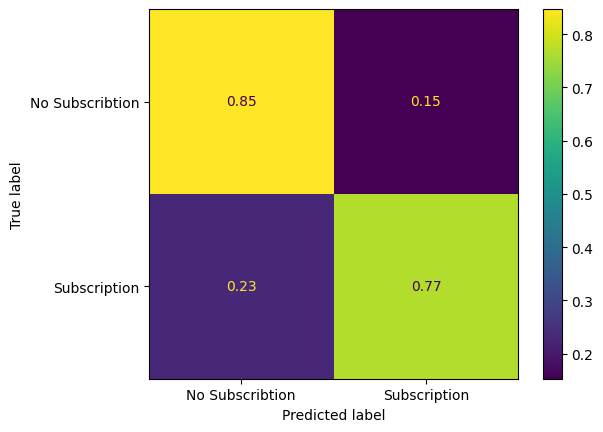

In [546]:
predictions = weighted_logit.predict(normalized_validation)
evaluate(predictions, validation_target)

#### Resampling

In [547]:
steps = [('oversampling', random_over_sampler), ('undersampling', random_under_sampler), ('classifier', LogisticRegression(random_state=0))]
logit_pipeline = Pipeline(steps)
pipelined_logit_hyperparameters = {"classifier__" + hyperparameter_name: hyperparameter_range
                                   for hyperparameter_name, hyperparameter_range
                                   in logit_hyperparameters.items()}


In [548]:
if not training:
    resampled_logit = load_model("models/resampled_logit.joblib")

else:
    pipelined_logit_hyperparameters["classifier__class_weight"] = [None]

    pipeline_hyperparameters = {**pipelined_logit_hyperparameters, **resampling_hyperparameters}
    resampled_logit = select_model(model=logit_pipeline,
                                   name="resampled_logit",
                                   train=normalized_train,
                                   target=train_target,
                                   hyperparameters=pipeline_hyperparameters, 
                                   iterations=100)

Recall: 0.6729166666666667
F2 Macro: 0.7320391085674645


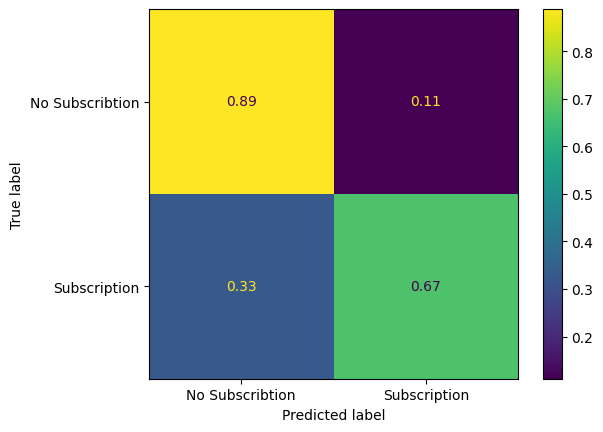

In [549]:
predictions = resampled_logit.predict(normalized_validation)
evaluate(predictions, validation_target)

#### Resampling + Class Weighting

In [550]:
if not training:
    resampled_weighted_logit = load_model("models/resampled_weighted_logit.joblib")

else:
    pipeline_hyperparameters = {**pipelined_logit_hyperparameters, **resampling_hyperparameters}
    resampled_weighted_logit = select_model(model=logit_pipeline,
                                            name="resampled_weighted_logit", 
                                            train=normalized_train,
                                            target=train_target,
                                            hyperparameters=pipeline_hyperparameters, 
                                            iterations=100)

Recall: 0.6729166666666667
F2 Macro: 0.7320391085674645


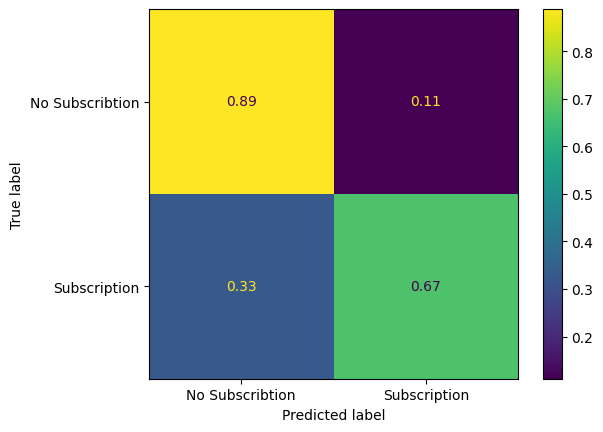

In [551]:
predictions = resampled_weighted_logit.predict(normalized_validation)
evaluate(predictions, validation_target)

### Extreme Gradient Boosting
XGBoost is a widely used model when dealing with tabular data.
It is a very flexible model with a built-in mechanism for class weighting and the possibility to deal with categorical features out of the box. 


In [552]:
xgb_general_hyperparameters = {
        # learning rate
        "eta": np.geomspace(0.1, 1, endpoint=False),
        # L1 regularization
        "alpha": np.linspace(0,1),
        # L2 regularization
        "lambda": np.linspace(0, 1),
        # subsample rate prior to growing the trees
        "subsample": np.linspace(0.1, 1),
        # solution method, only method supported for categorical features
        "tree_method": ["hist"],
}

xgb_classifier_to_train = xgb.XGBClassifier(random_state=0)

#### Class Weighting
Below we define the weight range for the built-in class weighting mechanism.

In [553]:
xgb_class_weighting_hyperparameters = {
        # weight to assign to each class
        "scale_pos_weight": np.linspace(3, 22),
}

##### Optimal Partitioning
Optimal partitioning allows to **deal with categorical variables without resorting to one-hot encoding**. The idea is to check whether a given value is among a set of categorical values to determine the split. The usual mechanism determines splits by checking whether a value is lower than a specified threshold. 

In [554]:
import xgboost as xgb

if not training:
    xgboost_partitioning = load_model("models/xgb_weighted_partitioning.joblib")

else:
    xgb_optimal_partitioning_hyperparameters = {
            # enable categorical feature support
            "enable_categorical": [True],
            # use optimal partitioning for all categorical features
            "max_cat_to_onehot": [1]
    }



    xgb_weighted_partitioning_hyperparameters = {**xgb_general_hyperparameters,
                                                 **xgb_optimal_partitioning_hyperparameters,
                                                 **xgb_class_weighting_hyperparameters}

    xgboost_partitioning = select_model(model=xgb_classifier_to_train,
                                        name = "xgb_weighted_partitioning",
                                        train=train, # no need for normalization in gradient boosting
                                        target=train_target,
                                        hyperparameters=xgb_weighted_partitioning_hyperparameters, 
                                        iterations=100)

Recall: 0.7625
F2 Macro: 0.7614204404451507


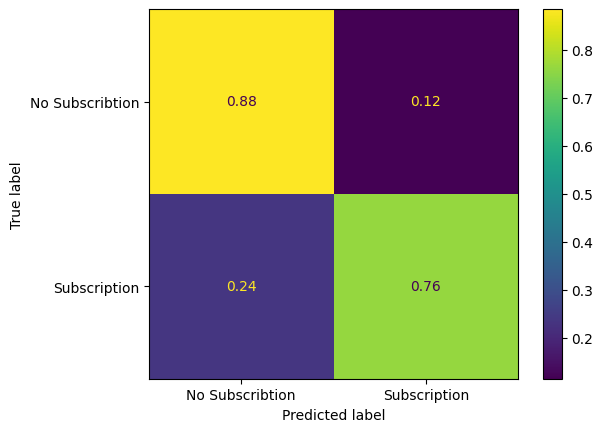

In [555]:
prediction = xgboost_partitioning.predict(validation)
evaluate(prediction, validation_target)

##### One-Hot Encoding
We run the same experiment as above but we use onehot-encoded categorical features.

In [556]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import numpy as np
from math import sqrt

if not training:
    xgboost_onehot = load_model("models/xgb_weighted_onehot.joblib")
    
else:
    xgb_weighted_onehot_hyperparameters = {**xgb_general_hyperparameters,
                                           **xgb_class_weighting_hyperparameters}


    xgboost_onehot = select_model(model=xgb_classifier_to_train,
                                   name="xgb_weighted_onehot",
                                   hyperparameters=xgb_weighted_onehot_hyperparameters,
                                   train=encoded_train,
                                   target=train_target,
                                   iterations=100)

Recall: 0.7708333333333334
F2 Macro: 0.767860625183464


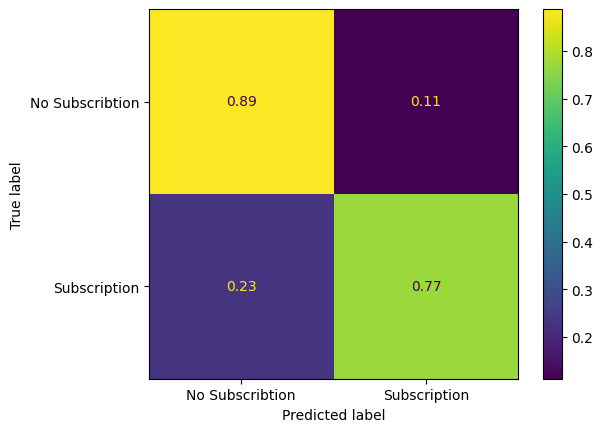

In [557]:
predictions = xgboost_onehot.predict(encoded_validation)
evaluate(predictions, validation_target)

#### Resampling

In [558]:
steps = [('oversampling', random_over_sampler), ('undersampling', random_under_sampler), ('classifier', xgb_classifier_to_train)]

pipeline = Pipeline(steps)

##### Optimal Partitioning


In [559]:
if not training:
    xgboost_partitioning_resample = load_model("models/xgb_resampled_partitioning.joblib")

else:
    xgb_unweighted_partitioning_hyperparameters = {**xgb_general_hyperparameters,
                                                   **xgb_optimal_partitioning_hyperparameters}

    pipelined_xgb_unweighted_partitioning_hyperparameters = {"classifier__" + hyperparameter_name: hyperparameter_range 
                                                            for hyperparameter_name, hyperparameter_range 
                                                            in xgb_unweighted_partitioning_hyperparameters.items()}

    xgb_resampled_partitioning_hyperparameters = {**pipelined_xgb_unweighted_partitioning_hyperparameters,
                                                  **resampling_hyperparameters}


    xgboost_partitioning_resample = select_model(model=pipeline,
                                                 name="xgb_resampled_partitioning",
                                                 hyperparameters=xgb_resampled_partitioning_hyperparameters,
                                                 train=train,
                                                 target=train_target,
                                                 iterations=100)



Recall: 0.7895833333333333
F2 Macro: 0.7746880442823474


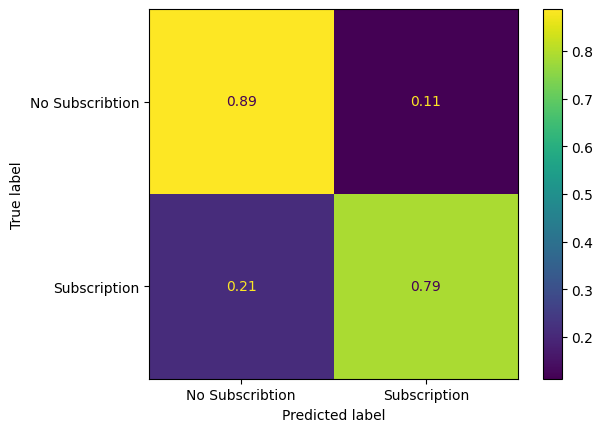

In [560]:
predictions = xgboost_partitioning_resample.predict(validation)
evaluate(predictions, validation_target)

##### One-Hot Encoding

In [561]:
if not training:
    xgboost_onehot_resample = load_model("models/xgb_resampled_onehot.joblib")
    
else:
    pipelined_xgb_general_hyperparameters = {"classifier__" + hyperparameter_name: hyperparameter_range 
                                                            for hyperparameter_name, hyperparameter_range 
                                                            in xgb_general_hyperparameters.items()}

    xgb_resampled_hyperparameters = {**pipelined_xgb_general_hyperparameters,
                                     **resampling_hyperparameters}


    xgboost_onehot_resample = select_model(model=pipeline, 
                                           name="xgb_resampled_onehot",
                                           hyperparameters=xgb_resampled_hyperparameters,
                                           train=encoded_train,
                                           target=train_target,
                                           iterations=100)



Recall: 0.7708333333333334
F2 Macro: 0.7709318548888333


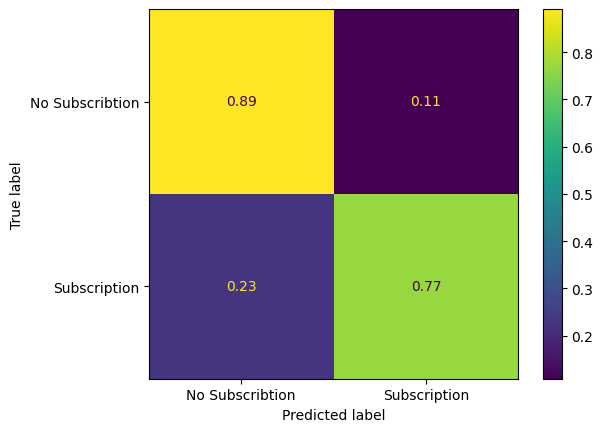

In [562]:
predictions = xgboost_onehot_resample.predict(encoded_validation)
evaluate(predictions, validation_target)

#### Class Weighting + Resampling

##### Optimal Partitioning

In [563]:
if not training:
    xgboost_partitioning_weighted_resample = load_model("models/xgb_resampled_weighted_partitioning.joblib")

else:
    pipelined_xgb_weighted_partitioning_hyperparameters = {"classifier__" + hyperparameter_name: hyperparameter_range 
                                                            for hyperparameter_name, hyperparameter_range 
                                                            in xgb_weighted_partitioning_hyperparameters.items()}

    xgb_weighted_resampled_partitioning_hyperparameters = {**pipelined_xgb_weighted_partitioning_hyperparameters,
                                                           **resampling_hyperparameters}


    xgboost_partitioning_weighted_resample = select_model(model=pipeline, 
                                                          name="xgb_resampled_weighted_partitioning",
                                                          hyperparameters=xgb_weighted_resampled_partitioning_hyperparameters,
                                                          train=train,
                                                          target=train_target,
                                                          iterations=100)

Recall: 0.84375
F2 Macro: 0.7648724725479197


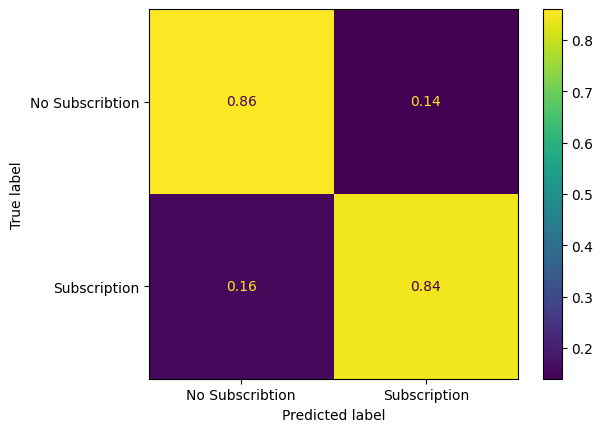

In [564]:
predictions = xgboost_partitioning_weighted_resample.predict(validation)
evaluate(predictions, validation_target)

##### One-Hot Encoding

In [565]:
if not training:
    xgboost_onehot_weighted_resample = load_model("models/xgb_resampled_weighted_onehot.joblib")

else:
    pipelined_xgb_weighted_hyperparameters = {"classifier__" + hyperparameter_name: hyperparameter_range 
                                                            for hyperparameter_name, hyperparameter_range 
                                                            in xgb_weighted_onehot_hyperparameters.items()}

    xgb_weighted_resampled_hyperparameters = {**pipelined_xgb_weighted_hyperparameters,
                                     **resampling_hyperparameters}


    xgboost_onehot_weighted_resample = select_model(model=pipeline,
                                           name="xgb_resampled_weighted_onehot",
                                           hyperparameters=xgb_weighted_resampled_hyperparameters,
                                           train=encoded_train,
                                           target=train_target,
                                           iterations=100)



Recall: 0.8125
F2 Macro: 0.7551976322700464


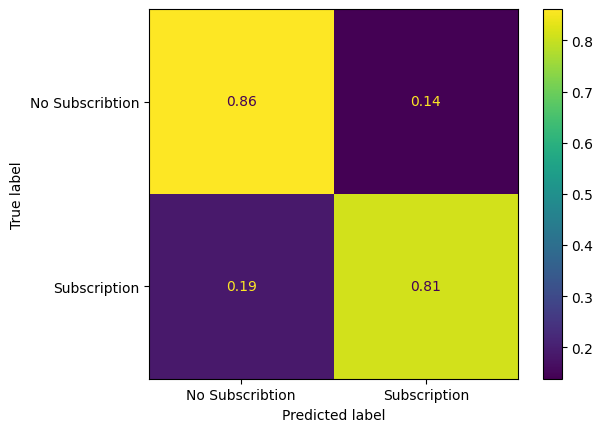

In [566]:
predictions = xgboost_onehot_weighted_resample.predict(encoded_validation)
evaluate(predictions, validation_target)

### Best Model
The best model is: **Extreme Gradient Boosting with Optimal Partitioning, Class Weighting and Resampling**.
We first evaluate its performance on a test set which was left out to avoid information leakage.

#### Model Performance on Test Set

In [567]:
best_model = xgboost_partitioning_weighted_resample["classifier"]
best_over_sampling = xgboost_partitioning_resample["oversampling"]
best_under_sampling = xgboost_partitioning_resample["undersampling"]

Recall: 0.8233333333333334
F2 Macro: 0.7601188303532547


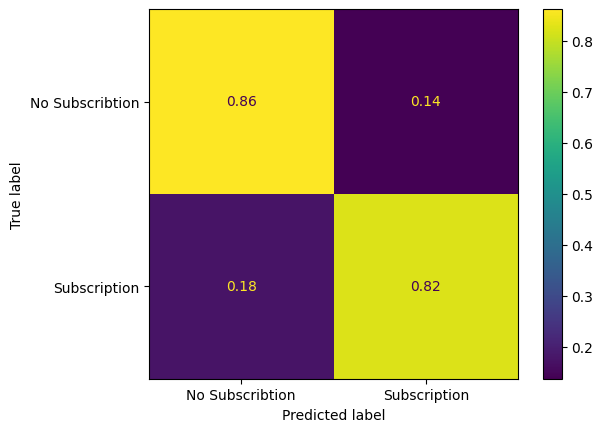

In [568]:
predictions = best_model.predict(test)
evaluate(predictions, test_target)

#### Model Explanation
Feature importance stresses how **last contact duration is crucial in predicting subscriptions**. This is to be expected as a longer last call means that the customer is truly interested in subscribing and likely asks for further details about the subscription. Partial Dependence plots confirms that long duration calls have greater impact on classification output. Finally from the misclassified samples we can clearly see that **misclassified samples have lower mean last contact duration with respect to the whole test set**.

Partial dependence plots also highlight how samples without a housing loan play a very important role in determining classification outcome. Many misclassified samples do not have a housing loan and are classified as subscribing customers. This may be an area of improvement for our model.

In [569]:
print("Oversampling Ratio: " + str(best_over_sampling.get_params()["sampling_strategy"]))
print("Undersampling Ratio: " + str(best_under_sampling.get_params()["sampling_strategy"]))
print("Class Weighting: " + str(best_model.get_params()["scale_pos_weight"]))

Oversampling Ratio: 0.19387755102040816
Undersampling Ratio: 0.6836734693877551
Class Weighting: 3.0


##### Permutation Feature Importance

In [ ]:
from sklearn.inspection import permutation_importance
feature_importance = pd.DataFrame()
feature_importance["feature"] = test.columns
feature_importance["value"] = permutation_importance(best_model, test, test_target, n_repeats=30, random_state=0, scoring=f2_macro_score)["importances_mean"]
feature_importance = feature_importance.sort_values(by="value", ascending=False)
histogram = px.histogram(feature_importance, x="feature", y="value")
histogram.update_traces(marker_color="#62a6ff")
histogram.update_traces(marker_line_width=0, opacity=0.6)
histogram["layout"]["xaxis"]["title"] = "Feature"
histogram["layout"]["yaxis"]["title"] = "Importance Value"
histogram.update_layout(template="simple_white", bargap=0.15, title="Permutation Feature Importance")

##### Partial Dependence Plot

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

PartialDependenceDisplay.from_estimator(best_model, test, ["duration"])

In [ ]:
PartialDependenceDisplay.from_estimator(best_model, test, ["housing"], categorical_features=["housing"])

##### Misclassified Samples Analysis

In [ ]:
import numpy as np

misclassified_samples_index = np.where(predictions != test_target)
misclassified_samples = test.iloc[misclassified_samples_index]
misclassified_samples.insert(len(misclassified_samples.columns), "predictions", predictions[np.where(predictions != test_target)].astype(str))
misclassified_samples.describe(include="all")

In [ ]:
test.describe(include="all")